## <CENTER> Anpassningar i ROOT: tips och exempel

Importera först de ROOT-klasser som behövs för att göra dem tillgängliga i python-miljön:

In [1]:
from ROOT import TH1F, TCanvas, TF1, TGraphErrors, TLegend, kRed, kBlue, kGreen, kBlack

Welcome to JupyROOT 6.14/00


### 2.1 Osäkerheter
___________________________________

In [3]:
# create a histogram
histo = TH1F("histo", "Events; x; Number of events", 20, -3., 3.)
# number of entries
N = 500
# fill the histogram with randomized values from a function
fname = "expo" # for example the pre-defined function "expo" with the two parameters p0 and p1: e^([p0] + [p1]*x). Other examples: "gaus", "landau"...
histo.FillRandom(fname, N) # fill N times

Warning in <TROOT::Append>: Replacing existing TH1: histo (Potential memory leak).


In [4]:
# [SWE]: aktivera interaktiv visualisering
# [ENG]: activate interactive visualisation
%jsroot on

In [6]:
canvas = TCanvas("canvas", "Test fits", 800, 600)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


In [7]:
# [SWE]: Rita histogrammet
# [ENG]: Draw the histogram
histo.Draw("e1")
canvas.Draw()

#### Ni ser att varje datapunkt har en osäkerhet. Ta reda på vad denna osäkerhet är lika med.

**Tips:** Håll pekaren över en datapunkt för att se dess värde och dess osäkerhet.

___________________________________________
### 2.2 Gör en anpassning 
Nu ska vi göra en anpassning av en funktion till data i histogrammet ovan. Syntax är `TH1F::Fit(fcn, "fit_opt", "draw_opt", xlow, xup)`
där 
* `fcn` är antingen en sträng med namnet på en funktion (ett `ROOT::TF1`-objekt), eller själva funktionsobjektet.
* sedan kommer anpassnings- och plot-alternativ, t.ex. `fit_opt = "V"` för mer detaljerad output och `draw_opt="E"` för att rita histogrammet med osäkerheter. Flera bokstäver bakas ihop i en och och samma sträng för att aktivera flera alternativ samtidigt. 
* sist är vilket intervall på x-axeln (nedre och övre gräns) i vilken anpassningen ska göras.

För mer information, see [dokumentationen för TH1::Fit()](https://root.cern.ch/doc/master/classTH1.html#a7e7d34c91d5ebab4fc9bba3ca47dabdd). Framförallt kan man läsa om de olika alternativen för att kontrollera anpassningen (mer om detta snart).

Vi testar först att helt enkelt att anpassa till den fördefinierade funktionen "expo" som användes för att fylla histogrammet (borde per definition ge en bra anpassning).
Genom att ropa på Fit görs anpassningen och den resulterande kurvan ritas upp. 
Per default används en viktad minsta-kvadrat-anpassning, även kallad $\chi^2$-anpassning (se "Statistik för fysikexperiment.pdf" på Canvas)
____________________________________________________________________________________

In [9]:
fitresult = histo.Fit(fname, "S") # option "S" makes sure the fit result is returned
print("\n****** Fit results: ")
canvas.Draw() 


****** Fit results: 
 FCN=6.62731 FROM MIGRAD    STATUS=CONVERGED      49 CALLS          50 TOTAL
                     EDM=1.07821e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.96695e+00   1.16531e-01   6.07041e-05   1.38219e-03
   2  Slope        1.02076e+00   5.24533e-02   2.73217e-05   5.36806e-03


Ovan ser ni resultaten från anpassningen. Titta t.ex. på `STATUS` som visar om anpassningen konvergerat (hittat minimum) eller inte. Ni ser de resulterade best-fit-värdena på parametrarna och deras respektive osäkerheter. Med fit option `"V"` ("verbose") skrivs mer detaljerad information ut.

Skriv ut den relativa osäkerheten på exponent-parametern nedan!

Tips: `fitresult` är ett objekt av klassen `TFitResult`, och ni kan komma åt parametervärden med funktionsanropet 'Parameter(i)'. Titta på [dokumentationen för TFitResult](https://root.cern.ch/doc/master/classROOT_1_1Fit_1_1FitResult.html) för att hitta funktionen som returnerar osäkerheten på de parametervärden som anpassningen gav.

In [ ]:
# print("Relative uncertainty Slope = ...."

#### Testa nu att gå tillbaka och öka antalet entries i histogrammet till det dubbla. Kör om anpassningen. Vad händer med osäkerheten? Om ni ökar med en faktor fyra? Kan ni förklara varför?

___________________________________________________________________________

### 2.3   Anpassningskvalitet: passar min modell mätdatan?
Hur kan vi kvantifiera hur bra en anpassning är? Ett sätt är att utnyttja faktumet att minsta-kvadrat-summan under vissa villkor följer en $\chi^2$-fördelning. Antalet frihetsgrader ($N_\rm{DOF}$) för fördelningen är lika med antalet datapunkter (binnar) minus antalet parametrar som ska anpassas. Med detta kan man räkna ut sannolikheten att få det värde på summan som observerats. Ett något grövre mått är att jämföra minsta-kvadrat-summan med antalet frihetsgrader. Kvoten mellan dem ska vara nära 1 för en bra anpassning. Detta kan förstås genom att notera att varje datapunkt bör bidra med i snitt värdet 1 i summan. Kvoten kallas för "reduced chi-square". 

OBS! Var dock försiktig med användandet av detta mått i olika sammanhang: summan följer en $\chi^2$-fördelning endast om modellen är korrekt och linjär i parametrarna, om datapunkterna är ungefär normalfördelade och om osäkerheterna är korrekt uppskattade.

Nedan tittar vi närmare på detta genom att göra en anpassning till en fyrkantspuls.
Se uppgiften längre ner.

In [11]:
import math
# create a histogram and populate it to create a square pulse that we can use to generate random values
squareWave = TH1F("squareWave", "Square; x; y", 3, 0.5, 3.5)
squareWave.SetBinContent(1, 5.); squareWave.SetBinError(1, math.sqrt(5.))
squareWave.SetBinContent(2, 15.); squareWave.SetBinError(2, math.sqrt(15.))
squareWave.SetBinContent(3, 5.); squareWave.SetBinError(3, math.sqrt(5.))
squareWave.SetLineColor(kBlack)

# sample the histogram and fill the random values into another histogram
sample_squareWave = TH1F("sample_squareWave", "; x; y", 15, 0.5, 3.5)
n=8000
sample_squareWave.FillRandom(squareWave, n)

# draw the original model and the sampled distribution
sample_squareWave.Draw("e1")
squareWave.Scale(float(n)/((15.+5.+5.)/3)/sample_squareWave.GetNbinsX()) 
squareWave.Draw("hist same")
canvas.Draw()

In [13]:
# now let's fit a constant function to this distribution, i.e. f = C
const = TF1("const", "[0]", 0.5, 3.5, 1) # the function just has one constant parameter and does not depend on x
const.SetParameter(0, 10.) # set the initial guess to 10
fitresult = sample_squareWave.Fit("const", "S", "SAME", 0.5, 3.5)
print("\n*** Chi-square sum = {:.1f}, Number of degrees of freedom = {}, ratio = {:.1f}".format(fitresult.Chi2(), fitresult.Ndf(), fitresult.Chi2()/fitresult.Ndf()))

canvas.Draw()


*** Chi-square sum = 1802.6, Number of degrees of freedom = 14, ratio = 128.8
 FCN=1802.63 FROM MIGRAD    STATUS=CONVERGED      12 CALLS          13 TOTAL
                     EDM=5.00266e-15    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.13158e+02   5.24822e+00   1.08831e-01   1.90591e-08


Som väntat lägger anpassningen linjen någonstans mellan den nedre och den övre delen av pulsen.
Från  utskriften ser ni att $\chi^2/N_\rm{DOF}$ är långt ifrån 1, dvs modellen beskriver inte vår data väl.

<b> Testa nu att bara anpassa en del av pulsen där en konstant borde ge en bra anpassning.
    Räkna ut $\chi^2/N_\rm{DOF}$. Är den närmare 1? </b>

____________________________________________________________________________
### 2.4 Konfigurering av anpassning
Default är som sagt att anpassa genom minimering av den viktade minsta-kvadrat-summan ($\chi^2$). Detta bygger på antagandet att de individuella mätvärdena kommer från normalfördelningar. I vårt fall gäller att de är Poisson-fördelade – men vi vet att Poisson-fördelningen närmar sig normalfördelningen då väntevärdet är stort.

Man kan också ge `fitOption = "L"` för att göra en sk maximum-likelihood-anpassning. I denna maximeras istället en sannolikhetsfunktion som är lika med en produkt av Poisson-termer där varje faktor representerar antal counts i en bin.

Låt oss jämföra de två alternativen med ett exempel. Betrakta en modell som är en rät linje. Vi genererar ett antal event och ritar upp ett histogram som motsvarar observationen av ett experiment. Målet är att mäta linjens lutning genom att göra en anpassning.
_______________________________________________________________________________

In [14]:
# a simple straight-line model, y = kx + m
xlow = 3.; xup = 10.
fmodel = TF1("lin", "[0]*x+[1]", xlow, xup)
# set initial parameter values
fmodel.SetParameters(1., 1.)
# create a histogram
hist = TH1F("exp", "; x; Number of events", 10, xlow, xup)
n = 30
hist.FillRandom("lin", n) # fill histogram with n randomly generated numbers from the function

# fit with the default least squares method
fitresult = hist.Fit("lin", "S", "e1") # store fit results using fit option "S"

# get parameters and their uncertainties
print(fitresult.Parameter(0))
print(fitresult.ParError(0))

# save the function and draw it again in blue (to prevent it from disappearing when drawing the same function again later)
fresultLeastSquares = hist.GetFunction("lin").Clone("linLeastSquares") # Clone() creates a copy of the function
fresultLeastSquares.SetLineColor(kBlue)
fresultLeastSquares.Draw("SAME")
print("\nSlope least squares = {:.3f}".format(fresultLeastSquares.GetParameter(0)))

# re-run the fit, this time with option "L". The resulting curve is shown in red
hist.Fit("lin", "L", "e1 SAME")
print("Slope likelihood = {:.3f}\n".format(hist.GetFunction("lin").GetParameter(0)))
canvas.Draw()

-0.0009274597651678373
0.31744170597230736

Slope least squares = -0.001
Slope likelihood = 0.471

 FCN=5.14974 FROM MIGRAD    STATUS=CONVERGED      30 CALLS          31 TOTAL
                     EDM=6.1757e-23    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -9.27460e-04   3.17442e-01   9.48678e-05  -9.36228e-11
   2  p1           2.76749e+00   2.24423e+00   6.70689e-04  -1.65535e-11
 FCN=5.09333 FROM MIGRAD    STATUS=CONVERGED      51 CALLS          52 TOTAL
                     EDM=1.41787e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.70971e-01   2.95743e-01   1.37479e-04  -1.06020e-04
   2  p1          -6.13195e-02   1.84050e+00   8.55547e-04   4.81844e-05
        

_______________________________________________________________
#### Som ni ser får vi inte samma lutning med de olika alternativen för anpassning. Testa vad som händer om ni ökar antalet event i histogrammet. Förklara.

### 2.5 Definiera egna funktioner
____________________________________________________________________

In [16]:
# NB the interactive feature unfortunately does not work for all functions. Turn off to make sure everything is drawn correctly.
%jsroot off

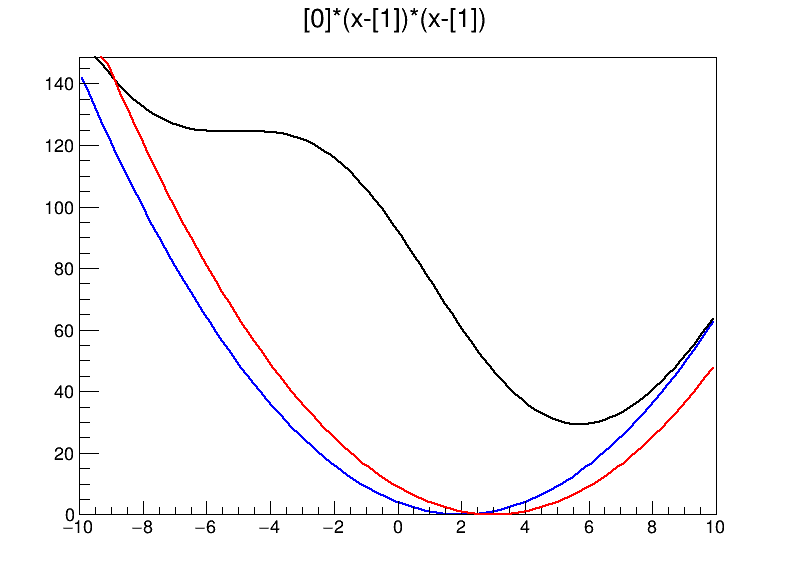

In [17]:
# define your own function, starting with a*(x-b)^2

# alternative 1: write the formula as a string using "TFormula"-syntax
f1 = TF1("f1", "[0]*(x-[1])*(x-[1])", -10., 10.) # [SWE]: [i] representerar parametrar, de två sista argumenten är range för funktionen
                                                 # [ENG]: [i] represent parameters, the last two arguments are the range for the function

# alternative 2: write with already existing functions (pre-defined eller user defined)
f2 = TF1("f2", "gaus + f1", -10., 10.)

# alternative 3: using your own python function
def myfunc(x, params):
    x=x[0]
    a=params[0]; b=params[1]
    return a*(x-b)**2
f3 = TF1("f3", myfunc, -10., 10., 2) # the last argument specifies the number of parameters

# set parameter values
f1.SetParameters(1., 2.)
f2.SetParameters(100., -2., 4., 1., 2.) # the first three parameters are for the Gaussian, the last for the f1 function
f3.SetParameters(1., 3.)

# set limits for the parameters (that they are forced to stay inside) Useful to fitting
f1.SetParLimits(0, -3., 5.) # parameter0 must lie inside [-3., 5.] 

# colors for drawing
f1.SetLineColor(kBlue)
f2.SetLineColor(kBlack)
f3.SetLineColor(kRed)

# draw
f1.Draw()
f2.Draw("SAME")
f3.Draw("SAME")
canvas.Draw()

___________________________________________________

### 2.6 Rita en legend
Generellt ska figurer ha en "legend" som visar vad de olika uppritade kurvorna/datapunkterna representerar. Nedan följer ett exempel. Se [dokumentationen för klassen TLegend](https://root.cern.ch/doc/master/classTLegend.html) för ytterligare dokumentation.
_________________________________________________________________________________

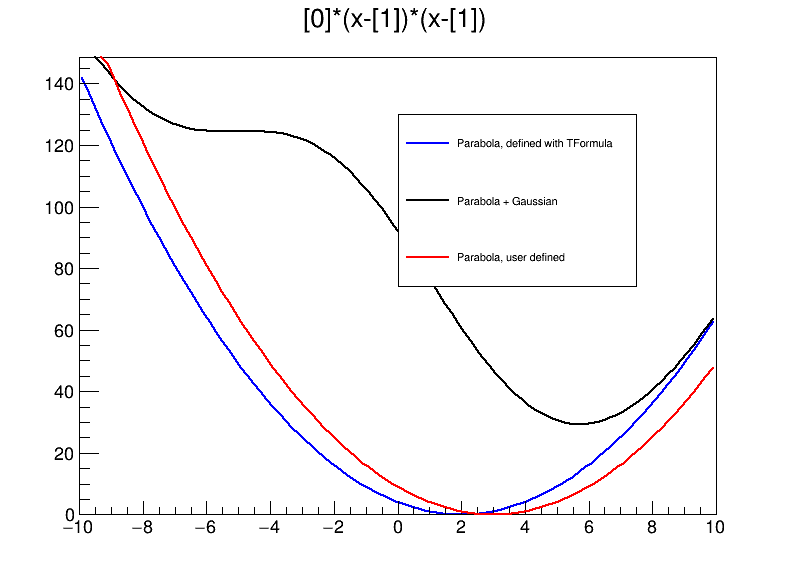

In [18]:
# create the legend object
leg = TLegend(0.5, 0.5, 0.8, 0.8) # the arguments are x1,y1,x2,y2-coordinates, given as fraction of canvas

# add the curves we drew above to the legend. Syntax is TLegend::AddEntry(drawn_object, title, plot_style)
leg.AddEntry(f1, "Parabola, defined with TFormula", "l") # here "l" (small L) represents "line"
leg.AddEntry(f2, "Parabola + Gaussian", "l")
leg.AddEntry(f3, "Parabola, user defined", "l") # had we drawn a histogram we could used "p" 

# make legend prettier (see below)
# ...

# draw legend
leg.Draw()
canvas.Draw()

Se till att texten i legenden inte är för liten. Detta kan styras med `leg.SetTextSize(x)` där `x` är andel av canvas-storleken. Kanten kan tas bort med `leg.SetLegendBorderSize(0)`. Ändra i kodblocket ovan för att göra legenden snyggare.
_______________________________________________________________


### Besvara följande frågor. Ni kommer att behöva dem för att i rapporten förklara hur anpassningen görs. 
* För histogram som ritats med något av `e`-alternativen har osäkerheter på varje datapunkt. ROOT har automatiskt räknat ut osäkerheterna... hur då?
* Vad bestämmer osäkerheten på de anpassade parametrarna? Hur kan de minskas?
* ROOT anpassar per default med viktad minsta-kvadrat-metoden ($\chi^2$-anpassning). När är detta korrekt? Vad händer om vi anpassar med option `"L"`?